In [2]:
import pandas as pd  
import numpy as np
from datetime import datetime as dt
import lppls

In [14]:
df = pd.read_csv('ETF_bubble_v1.1/res_df.csv', encoding='gbk')

In [32]:
etf_df[etf_df['FUND_CODE'] == '512690.SH']

,FUND_CODE,FUND_NAME,TRADE_DT,S_DQ_AMOUNT,S_DQ_ADJOPEN,S_DQ_ADJCLOSE,S_DQ_ADJLOW,S_DQ_ADJHIGH
TRADE_DT,,,,,,,,
20200102,512690.SH,酒ETF,20200102,40592.320,1.190,1.183,1.164,1.190
20200103,512690.SH,酒ETF,20200103,37435.532,1.177,1.169,1.162,1.181
20200106,512690.SH,酒ETF,20200106,38823.248,1.167,1.160,1.155,1.170
20200107,512690.SH,酒ETF,20200107,34886.701,1.163,1.175,1.158,1.175
20200108,512690.SH,酒ETF,20200108,33715.881,1.165,1.170,1.165,1.177
...,...,...,...,...,...,...,...,...
20230725,512690.SH,酒ETF,20230725,1425212.655,2.158,2.203,2.150,2.211
20230726,512690.SH,酒ETF,20230726,775372.916,2.198,2.200,2.179,2.219
20230727,512690.SH,酒ETF,20230727,1292939.141,2.206,2.222,2.192,2.254


In [12]:
# read in data
etf_df = pd.read_csv('etf-trade-data-2020-2023.csv', encoding='gbk')
etf_lst = etf_df['FUND_CODE'].unique()
etf_df.index = etf_df['TRADE_DT']
current_date = max(etf_df['TRADE_DT'])

In [29]:
price = etf_df[etf_df['FUND_CODE'] == '159869.SZ']['S_DQ_ADJCLOSE']
date = etf_df[etf_df['FUND_CODE'] == '159869.SZ']['TRADE_DT']

time = pd.to_datetime(date, format='%Y%m%d')

In [26]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

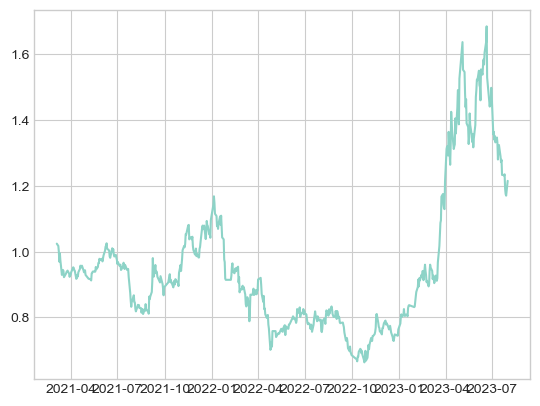

In [30]:
plt.plot(time, price)

In [3]:
def fit_price(dataframe):
    time = [pd.Timestamp.toordinal(dt.strptime(str(t1), '%Y%m%d')) for t1 in dataframe.index]
    price = np.log(dataframe['S_DQ_ADJCLOSE'].values)
    observations = np.array([time, price])
    lppls_model = lppls.LPPLS(observations=observations)
    lppls_model.mp_compute_nested_fits(
                workers=20,
                window_size=80,
                smallest_window_size=5,
                outer_increment=2,
                inner_increment=2,
                max_searches=25,
    )
    return dataframe, lppls_model

In [4]:
def filt_indicator(dataframe, lppls_model, filter_conditions_config = None):
    res_df = lppls_model.compute_indicators(lppls_model.indicator_result, filter_conditions_config)
    res_df['time'] = [pd.Timestamp(pd.Timestamp.fromordinal(int(t1)).strftime('%Y-%m-%d %H:%M:%S')) for t1 in res_df['time']]
    dataframe['time'] = pd.to_datetime(dataframe['TRADE_DT'], format='%Y%m%d')
    dataframe=dataframe.merge(res_df, on='time')
    return dataframe

In [ ]:
res_df = pd.DataFrame()
for etf_code in etf_lst:
    single_etf = etf_df[etf_df['FUND_CODE'] == etf_code][-80:]
    if len(single_etf) >= 80:
        dataframe, lppls_model = fit_price(single_etf)
        temp_df = filt_indicator(dataframe, lppls_model)
        res_df = pd.concat([res_df, temp_df[['TRADE_DT', 'FUND_CODE', 'neg_conf', 'pos_conf']]]).reset_index(drop=True)
# time 6m13.8s